# 打车软件

---

## 概述

数据来源：

<https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page>


数据描述：

<https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf>

In [190]:
import os
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [187]:
data = pd.read_csv("data/yellow_tripdata_2020-06.csv")
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-06-01 00:31:23,2020-06-01 00:49:58,1.0,3.6,1.0,N,140,68,1.0,15.5,3.0,0.5,4.00,0.0,0.3,23.30,2.5
1,1.0,2020-06-01 00:42:50,2020-06-01 01:04:33,1.0,5.6,1.0,N,79,226,1.0,19.5,3.0,0.5,2.00,0.0,0.3,25.30,2.5
2,1.0,2020-06-01 00:39:51,2020-06-01 00:49:09,1.0,2.3,1.0,N,238,116,2.0,10.0,0.5,0.5,0.00,0.0,0.3,11.30,0.0
3,1.0,2020-06-01 00:56:13,2020-06-01 01:11:38,1.0,5.3,1.0,N,141,116,2.0,17.5,3.0,0.5,0.00,0.0,0.3,21.30,2.5
4,1.0,2020-06-01 00:16:41,2020-06-01 00:29:30,1.0,4.4,1.0,N,186,75,1.0,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5


In [33]:
# import pandas_profiling
# pfr = pandas_profiling.ProfileReport(data)
# pfr.to_file('report.html')

## 数据分析

### 变量分析

对profiling得到的报告进行分析

|变量|含义|类型|待处理|
|:-|:-|:-|:-|
|VendorID|记录提供商|Categorical|缺省9.2%|
|tpep_pickup_datetime|上车时间|Datetime||
|tpep_dropoff_datetime|下车时间|Datetime||
|passenger_count|乘客数量|Categorical Number|缺省9.2%，零值2.4%|
|trip_distance|打车距离|Contiguous Number|零值3.2%，存在异常值(极大值)|
|RatecodeID|价格代码|Categorical Number|缺省9.2%|
|store_and_fwd_flag|是否保存在车辆内存中|Boolean|缺省9.2%|
|PULocationID|上车区域ID|Categorical Number||
|DOLocationID|下车区域ID|Categorical Number||
|payment_type|支付类别|Categorical Number|缺省9.2%|
|fare_amount|距离计价|Contiguous Number|存在异常值(负值，极大值)|
|extra|附加费|Contiguous Number|零值47.8%(正常)|
|mta_tax|交通税|Categorical Number|两类|
|tip_amount|小费|Contiguous Number|零值41.0%(正常)|
|tolls_amount|过路费|Contiguous Number|零值94.7%(正常)，存在异常值(极大值)|
|improvement_surcharge|改善附加费|Categorical Number|两类，存在异常值(负值)|
|total_amount|总费用|Contiguous Number|存在异常值(负值，极大值)|
|congestion_surcharge|拥挤附加费|Categorical Number|两类，存在异常值(负值)|

### 上下车差值

有1-265个区域，我们以一个小时为观测时间，该段时间内该区域下车记录减去上车记录，存在正负值（负值表示上车的车辆数更多）

In [195]:
time_format ="%Y-%m-%d %H:%M:%S"

def cal_diff(filename):
    data = pd.read_csv(filename).drop(columns=['Unnamed: 0'])
    year_month = filename.split("_")[-1].split(".")[0]
    
    start_time = datetime.strptime(year_month, "%Y-%m")
    end_time = start_time + relativedelta(months = 1)

    # start_time = "2020-6-1 00:00:00"
    # end_time = "2020-6-2 00:00:00"

    # start_time = datetime.strptime(start_time, time_format)
    # end_time = datetime.strptime(end_time, time_format)

    data["tpep_pickup_datetime"] = pd.to_datetime(data["tpep_pickup_datetime"])
    data["tpep_dropoff_datetime"] = pd.to_datetime(data["tpep_dropoff_datetime"])

    res_times = []
    res_datas = []

    print("Calculating file %s ..." % filename)

    while start_time < end_time:
        # print(start_time)
        # res_times.append(datetime.strftime(start_time, time_format))
        res_times.append(start_time)
        
        tmp = start_time + timedelta(hours = 1)

        # 对每个小时进行统计
        res_data = np.zeros(265, dtype=np.int)

        pickup = data.loc[(data["tpep_pickup_datetime"] > start_time) & (data["tpep_pickup_datetime"] < tmp)]["PULocationID"]
        pickup.reset_index(drop=True, inplace=True)
        dropoff = data.loc[(data["tpep_dropoff_datetime"] > start_time) & (data["tpep_dropoff_datetime"] < tmp)]["DOLocationID"]
        dropoff.reset_index(drop=True, inplace=True)
        for i in range(pickup.shape[0]):
            res_data[pickup[i] - 1] -= 1
        for i in range(dropoff.shape[0]):
            res_data[dropoff[i] - 1] += 1
        
        res_datas.append(res_data)

        start_time = tmp

    res_times = pd.DataFrame(np.array(res_times)).rename(columns = {0: 'time'})
    res_datas = pd.DataFrame(np.array(res_datas))

    res = pd.concat([res_times, res_datas], axis = 1)
    res.to_csv("data/diff/%s.csv" % (year_month), index=False)
    print("Done!")

cal_diff("data/clear_data/new_yellow_tripdata_2020-06.csv")

Calculating file data/clear_data/new_yellow_tripdata_2020-06.csv ...
Done!


matplotlib画图

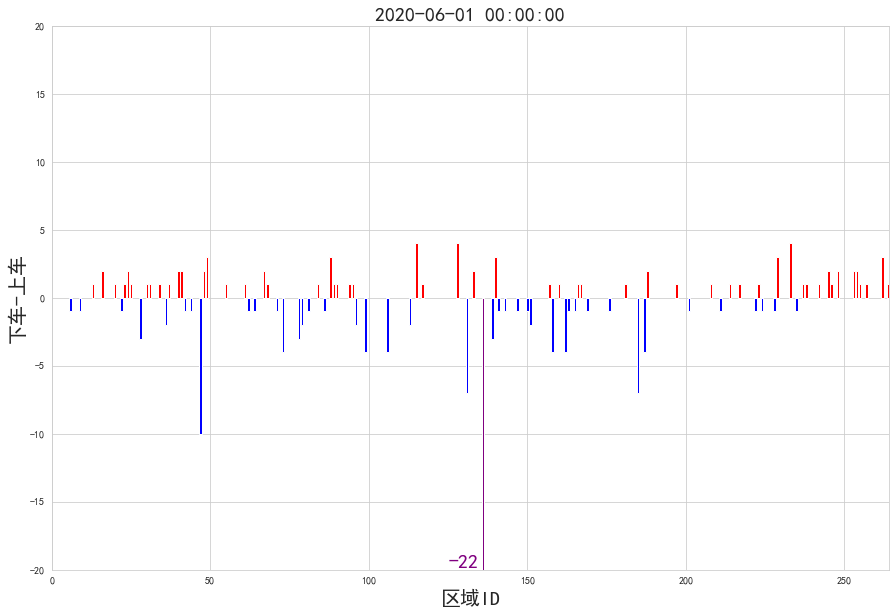

In [174]:
plt_data = res_datas.loc[0]
plt_data0 = plt_data.loc[(plt_data > 0) & (plt_data <= 20)]
plt_data1 = plt_data.loc[(plt_data < 0) & (plt_data >= -20)]
plt_data2 = plt_data.loc[plt_data > 20]
plt_data3 = plt_data.loc[plt_data < -20]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

ax.set_xlabel('区域ID', fontsize=20)
ax.set_ylabel('下车-上车', fontsize=20)
ax.set_xlim([0, 264])
ax.set_ylim([-20, 20])

title = ax.set_title(datetime.strftime(res_times[0], time_format), fontsize=20)

bar0 = ax.bar(x=plt_data0.index.values, height=plt_data0, color='r')
bar1 = ax.bar(x=plt_data1.index.values, height=plt_data1, color='b')
bar2 = ax.bar(x=plt_data2.index.values, height=plt_data2, color='orange')
bar3 = ax.bar(x=plt_data3.index.values, height=plt_data3, color='purple')
for a, b in zip(plt_data2.index.values, plt_data2):
    text0 = ax.text(a - 6, 18.5, '%.0f'%b, ha = 'center', va = 'bottom', fontsize=20, color='orange')
for a, b in zip(plt_data3.index.values, plt_data3):
    text1 = ax.text(a - 6, -20, '%.0f'%b, ha = 'center', va = 'bottom', fontsize=20, color='purple')

plt.show()